In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [2]:
df = pd.read_csv('src/household_power_consumption.txt', sep=';', na_values=['?', ''])

In [3]:
# преобразуем форматы даты и времени, соединяем в одну колонку и устанавливаем в качестве индекса
df['dt'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%d/%m/%Y %H:%M:%S'
)

df = df.set_index('dt')

df = df.drop(columns=['Date', 'Time'])

In [4]:
# заполянем пропущенные значения (интерполяция)
df = df.interpolate(method='linear')

In [5]:
# выбираем двухмесячный диапазон
start_date = '2006-12-15'
end_date = '2007-02-15'

df2m = df.loc[start_date:end_date]

In [6]:
df2m

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2007-02-15 23:55:00,1.656,0.190,244.13,6.8,0.0,1.0,18.0
2007-02-15 23:56:00,1.600,0.084,244.25,6.6,0.0,0.0,18.0
2007-02-15 23:57:00,1.562,0.000,244.89,6.4,0.0,0.0,19.0


In [7]:
# берем почасовой интервал (среднее по минутам)
df2m = df.loc[start_date:end_date].resample('h').mean()

In [8]:
dftest = adfuller(df2m.Global_active_power, autolag='AIC', maxlag=24)
print(f'p-value: {dftest[1]:.3f}')
print(f'statistic: {dftest[0]:.3f}')

p-value: 0.000
statistic: -5.713


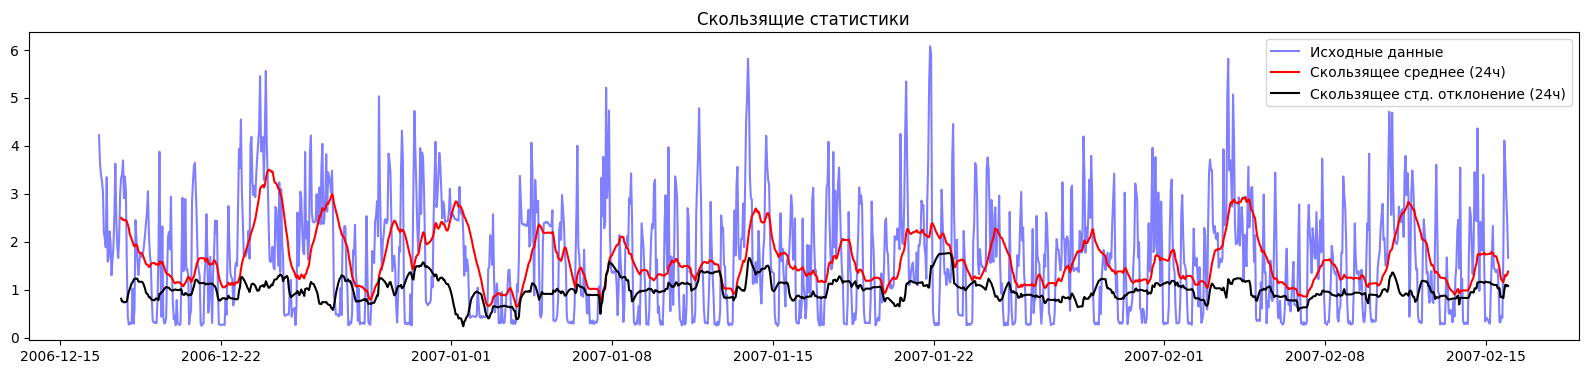

In [9]:
roll_mean = df2m.Global_active_power.rolling(window=24).mean()
roll_std = df2m.Global_active_power.rolling(window=24).std()

plt.figure(figsize=(20, 4))
plt.plot(df2m.Global_active_power, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (24ч)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (24ч)')
plt.legend(loc='best')
plt.title('Скользящие статистики')
plt.show()

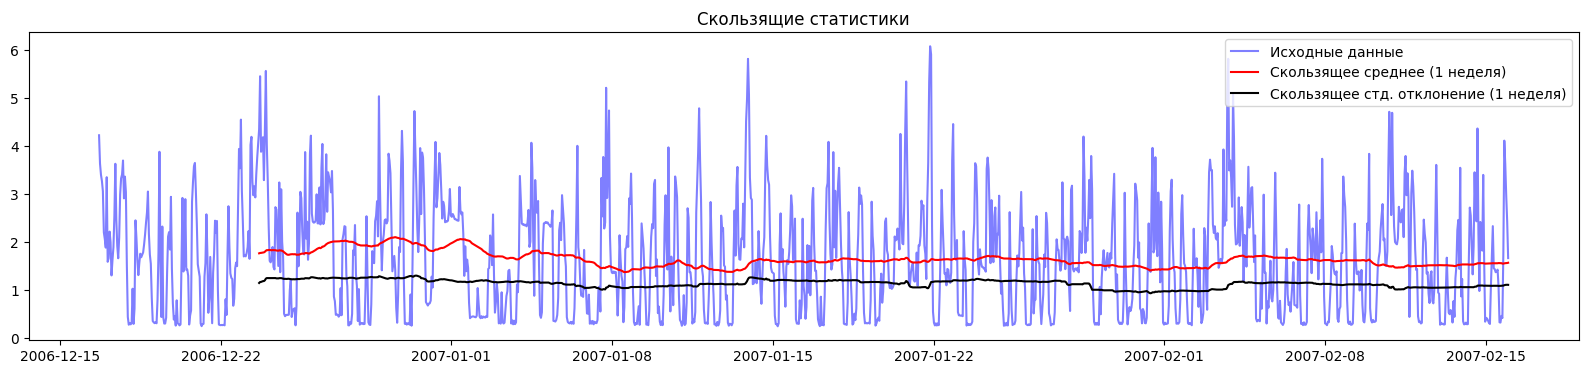

In [10]:
roll_mean = df2m.Global_active_power.rolling(window=168).mean()
roll_std = df2m.Global_active_power.rolling(window=168).std()

plt.figure(figsize=(20, 4))
plt.plot(df2m.Global_active_power, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (1 неделя)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (1 неделя)')
plt.legend(loc='best')
plt.title('Скользящие статистики')
plt.show()

In [11]:
df2m['log_Global_active_power'] = np.log(df2m['Global_active_power'] + 1e-6)

In [12]:
df2m['stationary_series'] = df2m['log_Global_active_power'].diff(24)

df_clean = df2m.dropna()

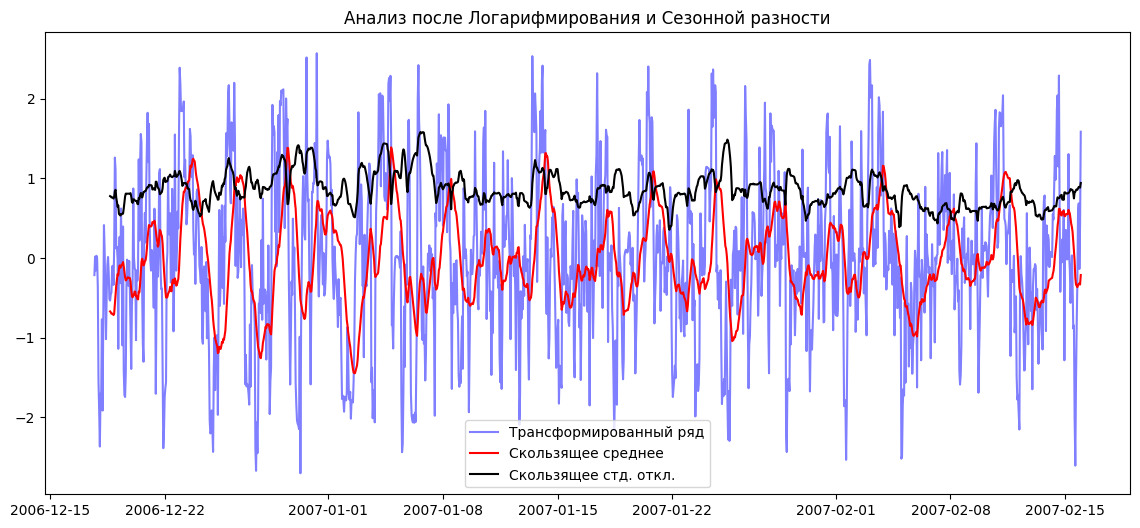

In [13]:
roll_mean = df_clean['stationary_series'].rolling(window=24).mean()
roll_std = df_clean['stationary_series'].rolling(window=24).std()

plt.figure(figsize=(14, 6))
plt.plot(df_clean['stationary_series'], color='blue', label='Трансформированный ряд', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее')
plt.plot(roll_std, color='black', label='Скользящее стд. откл.')
plt.legend(loc='best')
plt.title('Анализ после Логарифмирования и Сезонной разности')
plt.show()


In [14]:
train_data = np.log(df2m['Global_active_power'])

model = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(1, 0, 1),
                                  seasonal_order=(0, 1, 1, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

results = model.fit()

forecast_log = results.forecast(steps=24)

forecast_real = np.exp(forecast_log)

forecast_real

2007-02-16 00:00:00    0.970813
2007-02-16 01:00:00    0.707896
2007-02-16 02:00:00    0.606092
2007-02-16 03:00:00    0.545540
2007-02-16 04:00:00    0.510905
2007-02-16 05:00:00    0.617409
2007-02-16 06:00:00    1.187658
2007-02-16 07:00:00    2.064114
2007-02-16 08:00:00    1.951304
2007-02-16 09:00:00    1.587704
2007-02-16 10:00:00    1.327552
2007-02-16 11:00:00    1.310933
2007-02-16 12:00:00    1.291077
2007-02-16 13:00:00    1.100835
2007-02-16 14:00:00    1.185885
2007-02-16 15:00:00    1.198276
2007-02-16 16:00:00    1.080439
2007-02-16 17:00:00    1.253194
2007-02-16 18:00:00    2.008466
2007-02-16 19:00:00    2.604184
2007-02-16 20:00:00    2.532541
2007-02-16 21:00:00    2.421343
2007-02-16 22:00:00    1.634980
2007-02-16 23:00:00    1.033654
Freq: h, Name: predicted_mean, dtype: float64

______

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [16]:
def create_features(data, target_columns, lag_hours=[1, 24, 168]):
    """
    Создает признаки для ML модели на основе временного ряда.
    """
    df_feat = data.copy()
    
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['dayofmonth'] = df_feat.index.day
    cat_features = ['hour', 'dayofweek', 'dayofmonth']
    
    for col in target_columns:
        for lag in lag_hours:
            df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)
    
    for col in target_columns:
        df_feat[f'{col}_rolling_mean_24'] = df_feat[col].shift(1).rolling(window=24).mean()
    
    return df_feat, cat_features

In [17]:
# создание признаков
targets = df2m.columns.tolist()
df_features, cat_features = create_features(df2m, targets)
df_features = df_features.dropna()

In [18]:
# разбиение на train & test
test_size = 24 * 14  # 14 дней
split_date = df_features.index[-test_size]

train = df_features.loc[df_features.index < split_date]
test = df_features.loc[df_features.index >= split_date]

In [19]:
# обучение модели
models = {}
predictions = pd.DataFrame(index=test.index)
metrics = {}

feature_cols = [col for col in df_features.columns if col not in targets]

for target in targets:
    
    X_train = train[feature_cols]
    y_train = train[target]
    X_test = test[feature_cols]
    y_test = test[target]
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=cat_features)
    
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'verbose': -1
    }
    
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    models[target] = model
    preds = model.predict(X_test, num_iteration=model.best_iteration)
    predictions[target] = preds
    
    mae = mean_absolute_error(y_test, preds)
    metrics[target] = mae
    print(f"  MAE для {target}: {mae:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	training's l1: 0.177193	valid_1's l1: 0.489814
  MAE для Global_active_power: 0.4898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	training's l1: 0.0226961	valid_1's l1: 0.0451974
  MAE для Global_reactive_power: 0.0452
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	training's l1: 0.542721	valid_1's l1: 1.21574
  MAE для Voltage: 1.2157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	training's l1: 0.888261	valid_1's l1: 2.06765
  MAE для Global_intensity: 2.0676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	training's l1: 0.960409	valid_1's l1: 1.65338
  MAE для Sub_metering_1: 1.6534
Training until validation scores don't improve for 50 rounds
Early stopping, best iterat

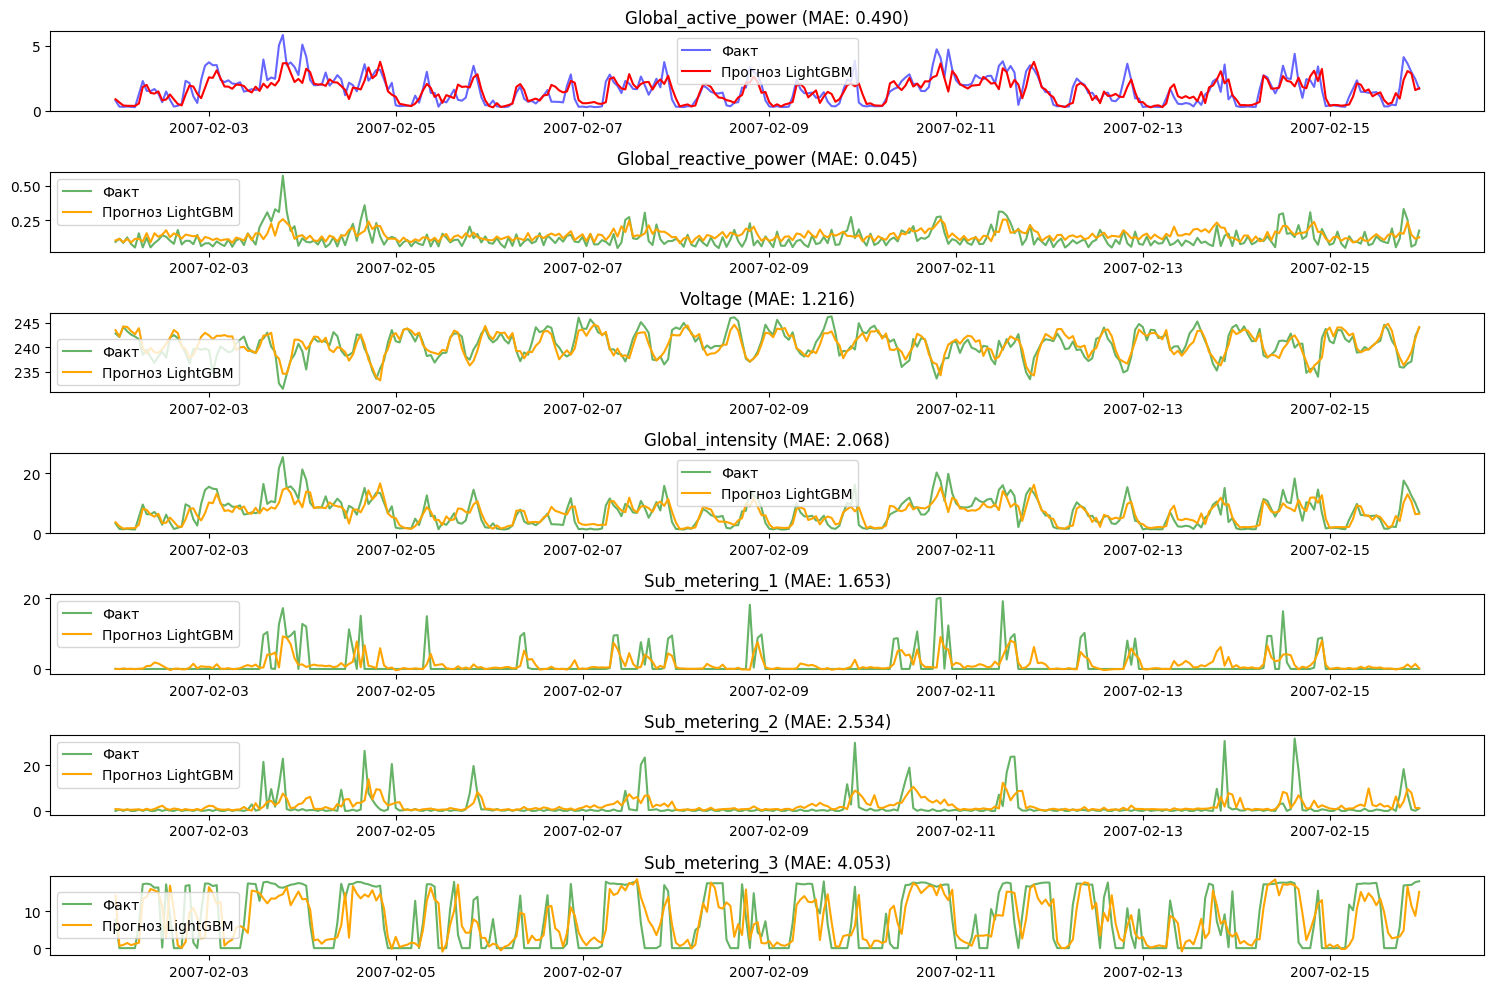

In [20]:
# Визуализация прогноза
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15, 10))

# Global_active_power
axes[0].plot(test.index, test['Global_active_power'], label='Факт', color='blue', alpha=0.6)
axes[0].plot(test.index, predictions['Global_active_power'], label='Прогноз LightGBM', color='red', linewidth=1.5)
axes[0].set_title(f'Global_active_power (MAE: {metrics["Global_active_power"]:.3f})')
axes[0].legend()

# Global_reactive_power
axes[1].plot(test.index, test['Global_reactive_power'], label='Факт', color='green', alpha=0.6)
axes[1].plot(test.index, predictions['Global_reactive_power'], label='Прогноз LightGBM', color='orange', linewidth=1.5)
axes[1].set_title(f'Global_reactive_power (MAE: {metrics["Global_reactive_power"]:.3f})')
axes[1].legend()

# Voltage
axes[2].plot(test.index, test['Voltage'], label='Факт', color='green', alpha=0.6)
axes[2].plot(test.index, predictions['Voltage'], label='Прогноз LightGBM', color='orange', linewidth=1.5)
axes[2].set_title(f'Voltage (MAE: {metrics["Voltage"]:.3f})')
axes[2].legend()

# Global_intensity
axes[3].plot(test.index, test['Global_intensity'], label='Факт', color='green', alpha=0.6)
axes[3].plot(test.index, predictions['Global_intensity'], label='Прогноз LightGBM', color='orange', linewidth=1.5)
axes[3].set_title(f'Global_intensity (MAE: {metrics["Global_intensity"]:.3f})')
axes[3].legend()

# Sub_metering_1
axes[4].plot(test.index, test['Sub_metering_1'], label='Факт', color='green', alpha=0.6)
axes[4].plot(test.index, predictions['Sub_metering_1'], label='Прогноз LightGBM', color='orange', linewidth=1.5)
axes[4].set_title(f'Sub_metering_1 (MAE: {metrics["Sub_metering_1"]:.3f})')
axes[4].legend()

# Sub_metering_2
axes[5].plot(test.index, test['Sub_metering_2'], label='Факт', color='green', alpha=0.6)
axes[5].plot(test.index, predictions['Sub_metering_2'], label='Прогноз LightGBM', color='orange', linewidth=1.5)
axes[5].set_title(f'Sub_metering_2 (MAE: {metrics["Sub_metering_2"]:.3f})')
axes[5].legend()

# Sub_metering_3
axes[6].plot(test.index, test['Sub_metering_3'], label='Факт', color='green', alpha=0.6)
axes[6].plot(test.index, predictions['Sub_metering_3'], label='Прогноз LightGBM', color='orange', linewidth=1.5)
axes[6].set_title(f'Sub_metering_3 (MAE: {metrics["Sub_metering_3"]:.3f})')
axes[6].legend()

plt.tight_layout()